<a href="https://colab.research.google.com/github/cnhzgb/MachineL/blob/main/VAE_CNN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
from einops import rearrange
import time
import torch.nn.functional as F
import ipdb
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device("mps")
print(torch.backends.mps.is_available(), torch.backends.mps.is_built(), device)

check_point_path = '/Users/bin.guanb/code/MachineL/model_state/VAE_CNN_MNIST'
epoch_cnt = 0
total_loss = []

True True mps


In [10]:
trans = transforms.Compose([transforms.ToTensor(), transforms.Pad(padding=(2,2),fill=0)])
dataset = datasets.MNIST(root="/Users/bin.guanb/code/MachineL/dataset/", transform=trans, download=True, train=True) # 6W张图片, 10种分类
loader = DataLoader(dataset, batch_size=100, shuffle=True)
batch_num,(image, label) = next(enumerate(loader))
print(len(dataset.classes), len(dataset), image.shape) # 10; 6W; 100,1,32,32

trans_test = transforms.Compose([transforms.ToTensor(), transforms.Pad(padding=(2,2),fill=0)])
dataset_test = datasets.MNIST(root="/Users/bin.guanb/code/MachineL/dataset/", transform=trans_test, download=True, train=False) # 1W张图片
loader_test = DataLoader(dataset_test, batch_size=100, shuffle=True)
print(len(dataset_test))

10 60000 torch.Size([100, 1, 32, 32])
10000


In [21]:
# https://github.com/SashaMalysheva/Pytorch-VAE/blob/master/model.py
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.encoder = nn.Sequential(
        self.conv(1,8), # ,8,16,16
        self.conv(8,32), # ,32,8,8
        self.conv(32,128) # ,128,4,4
    )
    self.decoder = nn.Sequential(
        # nn.Linear(2,256), nn.ReLU(), nn.Linear(256, 28*28), nn.Sigmoid()
        self.deconv(64,32), # ,32,8,8
        self.deconv(32,8), # ,8,16,16
        self.deconv(8,1), # ,1,32,32
        nn.Sigmoid()
    )

  def conv(self, inC, outC):
    return nn.Sequential(
        nn.Conv2d(inC, outC, kernel_size=4, stride=2, padding=1), # 除2处理
        nn.BatchNorm2d(outC), nn.ReLU()
    )

  def deconv(self, inC, outC):
    return nn.Sequential(
        nn.ConvTranspose2d(inC, outC, kernel_size=4, stride=2, padding=1), # 乘2处理
        nn.BatchNorm2d(outC), nn.ReLU()
    )

  def reparam(self, mean, logvar):
    epsilon = torch.randn_like(mean)
    return mean + epsilon * torch.exp(logvar/2)

  def kl_loss(self, mean, logvar):
    return ((mean**2 + logvar.exp() - 1 - logvar) / 2).mean()

  def gen_loss(self, gen_img, img):
    return nn.BCELoss(size_average=False)(gen_img, img) / img.size(0)

  def forward(self, x):
    #ipdb.set_trace()
    h = self.encoder(x) # ,128,4,4
    mean, logvar = h.chunk(2, dim=1) # ,64,4,4  + ,64,4,4
    h = self.reparam(mean, logvar) #,64,4,4
    out = self.decoder(h) #,1,32,32
    return out, mean, logvar

model = Net().to(device)
#print(model)
model_cpu = Net().to("cpu")
#summary(model_cpu, (32,32))

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

if os.path.exists(check_point_path):
  checkpoint = torch.load(check_point_path)
  model.load_state_dict(checkpoint['model_state'])
  optimizer.load_state_dict(checkpoint['optimizer_state'])
  epoch_cnt = checkpoint['epoch_cnt']
  total_loss = checkpoint['total_loss']

/Users/bin.guanb/Library/Python/3.9/lib/python/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


epoch:81 loss:666.94 mean:666.12 time:12.2


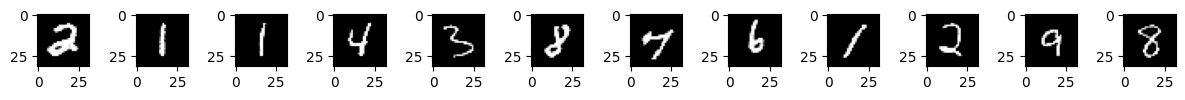

epoch:82 loss:668.54 mean:666.12 time:12.1


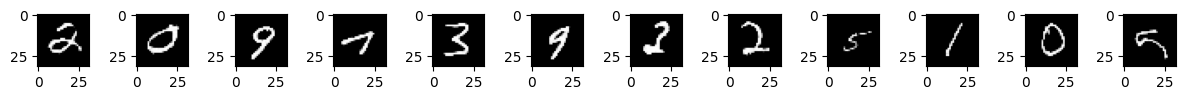

epoch:83 loss:664.61 mean:666.11 time:11.9


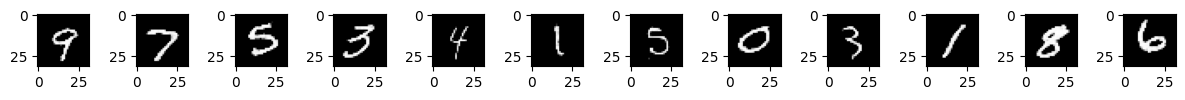

KeyboardInterrupt: ignored

In [26]:
for oneRound in range(1,100):
  epoch_loss = []
  startTime = time.time()
  for batch_idx, (img, label) in enumerate(loader):
    img = img.to(device)
    label = label.to(device)
    gen_img, mean, logvar = model(img)

    loss = model.gen_loss(gen_img, img) + model.kl_loss(mean, logvar)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epoch_loss.append(loss.item())

  epoch_cnt +=1
  total_loss.append(np.mean(epoch_loss))

  print("epoch:{} loss:{:.2f} mean:{:.2f} time:{:.1f}".format(
    epoch_cnt, loss, np.mean(epoch_loss), time.time()-startTime))
  with torch.no_grad():
    fig, axs = plt.subplots(1, 12, figsize=(12, 1))
    for i, ax in enumerate(axs.flatten()):
      ax.imshow(gen_img[i][0].cpu(), cmap='gray')
    plt.tight_layout()
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


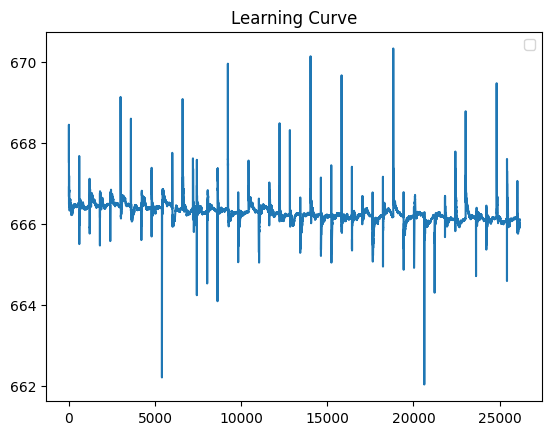

In [27]:
checkpoint = {
    'model_state': model.state_dict(),
    'optimizer_state': optimizer.state_dict(),
    'epoch_cnt' : epoch_cnt,
    'total_loss' : total_loss
}
torch.save(checkpoint, check_point_path)

plt.plot(total_loss)
plt.title("Learning Curve")
plt.legend();

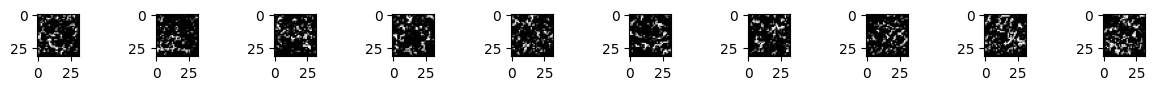

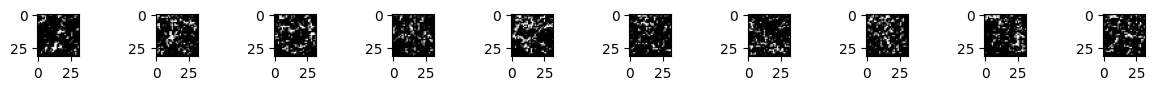

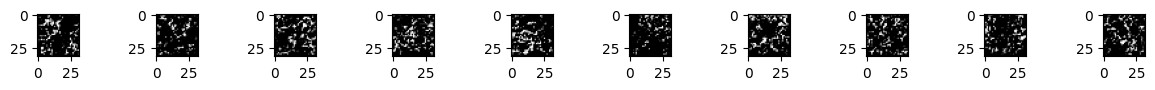

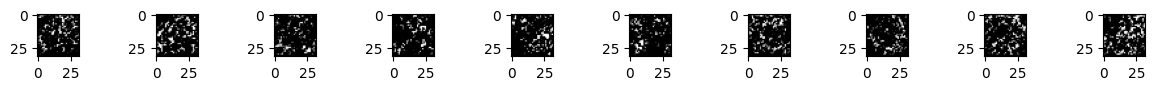

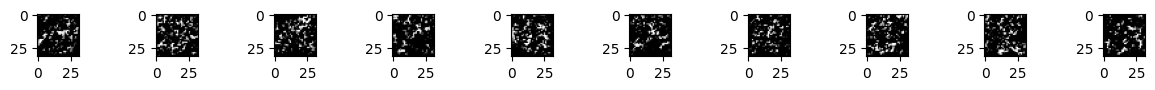

In [28]:
with torch.no_grad():
  for i in range(1,6):
    test = torch.randn(10,64,4,4).to(device)
    gen_img = model.decoder(test) # 10,32,32

    fig, axs = plt.subplots(1, 10, figsize=(12, 1))
    for i, ax in enumerate(axs.flatten()):
      ax.imshow(gen_img[i][0].cpu(), cmap='gray')
    plt.tight_layout()
    plt.show()